<h1 >Integrating Word2Vec Part1</h1>

## Import required libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns
from sklearn.manifold import TSNE

from IPython.core.display import display_svg,SVG


from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import Dataset


import logging
from gensim.models import Word2Vec
from collections import defaultdict
import torch
import torch.nn as nn
import torch.optim as optim
from torchtext.vocab import GloVe,vocab
from torchdata.datapipes.iter import IterableWrapper, Mapper
from torchtext.datasets import AG_NEWS
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset
from torchtext.data.utils import get_tokenizer
from torch.utils.data import DataLoader
from tqdm import tqdm

%matplotlib inline

# You can also use this section to suppress warnings generated by your code:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')


## Helper functions

<h3 style="color:blue"> A]. Function to plot word embeddings in a 2d space.</h3>

In [3]:
def plot_embeddings(word_embeddings, vocab=vocab):
    tsne = TSNE(
        n_components=2,
        random_state=0
    )
    word_embeddings_2d = tsne.fit_transform(word_embeddings)

    # plotting the results with labels for vocab
    plt.figure(figsize=(15, 15))
    for i, word in enumerate(vocab.get_itos() ):
        plt.scatter(word_embeddings_2d[i, 0], word_embeddings_2d[i, 1])
        plt.annotate(
            word,
            (word_embeddings_2d[i, 0], word_embeddings_2d[i, 1])
        )
    plt.xlabel("t-SNE component 1")
    plt.ylabel('t-SNE component 2')
    plt.title("Word Embeddings visualized with t-SNE")
    plt.show()

<h3 style="color:blue"> B]. Function that returns similar words to a specific word by calculating Cosine distance.</h3>

In [4]:
def find_similar_words(word, word_embeddings, top_k=5):
    if word not in word_embeddings:
        print("Word not found in embeddings.")
        return []

    # Get the embeddings for the given word
    target_embeddings = word_embeddings[word]

    # Calculate cosine similarities between the target word and all other words
    similarities = {}
    for w, embeddings in word_embeddings.items():
        if w != word:
            similarities = torch.dot(
                target_embeddings, embeddings
            ) / (
                torch.norm(target_embeddings) * torch.norm(embeddings)
            )
            similarities[w] = similarities.item()
    # Sort the similarities in descending order
    sorted_similarities = sorted(similarities.items(), key=lambda x: x[1], reverse=True)

    # Return the top k similar words
    most_similar_words = [w for w, _ in sorted_similarities[:top_k]]
    return most_similar_words

<h3 style="color:blue"> C]. Function that trains word2vec model on toy data. </h3>

In [5]:
def train_model(
        model,
        dataloader,
        criterion,
        optimizer,
        num_epochs=1000
):
    """
    Train the model for the specified number of epochs.

    Args:
        model: The PyTorch model to be trained.
        dataloader: DataLoader providing data for training.
        criterion: Loss function.
        optimizer: Optimizer for updating model's weights.
        num_epochs: Number of epochs to train the model for.

    Returns:
        model: The trained model.
        epoch_losses: List of average losses for each epoch.
    """

    # List to store running loss for each epoch
    epoch_losses = []

    for epoch in tqdm(range(num_epochs)):
        # Storing running loss values for current epoch
        running_loss = 0.0

        # Using tqdm for a progress bar
        for idx, samples in enumerate(dataloader):
            optimizer.zero_grad()

            # Check for EmbeddingBag Layer in the model
            if any(isinstance(module, nn.EmbeddingBag) for _, module in model.named_modules()):
                target, context, offsets = samples
                predicted = model(context, offsets)

            # Check for Embedding layer in the model
            elif any(isinstance(module, nn.Embedding) for _, module in model.named_modules()):
                target, context = samples
                predicted = model(context)

            loss = criterion(predicted, target)
            loss.backward()
            torch.nn.utils.clip_grad_norm(model.parameters(), 0.1)
            optimizer.step()
            running_loss += loss.item()

        # Append average loss for the epoch
        epoch_losses.append(running_loss / len(dataloader))

    return  model, epoch_losses


In [6]:
toy_data = """I wish I was little bit taller
I wish I was a baller
She wore a small black dress to the party
The dog chased a big red ball in the park
He had a huge smile on his face when he won the race
The tiny kitten played with a fluffy toy mouse
The team celebrated their victory with a grand parade
She bought a small, delicate necklace for her sister
The mountain peak stood majestic and tall against the clear blue sky
The toddler took small, careful steps as she learned to walk
The house had a spacious backyard with a big swimming pool
He felt a sense of accomplishment after completing the challenging puzzle
The chef prepared a delicious, flavorful dish using fresh ingredients
The children played happily in the small, cozy room
The book had an enormous impact on readers around the world
The wind blew gently, rustling the leaves of the tall trees
She painted a beautiful, intricate design on the small canvas
The concert hall was filled with thousands of excited fans
The garden was adorned with colorful flowers of all sizes
I hope to achieve great success in my chosen career path
The skyscraper towered above the city, casting a long shadow
He gazed in awe at the breathtaking view from the mountaintop
The artist created a stunning masterpiece with bold brushstrokes
The baby took her first steps, a small milestone that brought joy to her parents
The team put in a tremendous amount of effort to win the championship
The sun set behind the horizon, painting the sky in vibrant colors
The professor gave a fascinating lecture on the history of ancient civilizations
The house was filled with laughter and the sound of children playing
She received a warm, enthusiastic welcome from the audience
The marathon runner had incredible endurance and determination
The child's eyes sparkled with excitement upon opening the gift
The ship sailed across the vast ocean, guided by the stars
The company achieved remarkable growth in a short period of time
The team worked together harmoniously to complete the project
The puppy wagged its tail, expressing its happiness and affection
She wore a stunning gown that made her feel like a princess
The building had a grand entrance with towering columns
The concert was a roaring success, with the crowd cheering and clapping
The baby took a tiny bite of the sweet, juicy fruit
The athlete broke a new record, achieving a significant milestone in her career
The sculpture was a masterpiece of intricate details and craftsmanship
The forest was filled with towering trees, creating a sense of serenity
The children built a small sandcastle on the beach, their imaginations running wild
The mountain range stretched as far as the eye could see, majestic and awe-inspiring
The artist's brush glided smoothly across the canvas, creating a beautiful painting
She received a small token of appreciation for her hard work and dedication
The orchestra played a magnificent symphony that moved the audience to tears
The flower bloomed in vibrant colors, attracting butterflies and bees
The team celebrated their victory with a big, extravagant party
The child's laughter echoed through the small room, filling it with joy
The sunflower stood tall, reaching for the sky with its bright yellow petals
The city skyline was dominated by tall buildings and skyscrapers
The cake was adorned with a beautiful, elaborate design for the special occasion
The storm brought heavy rain and strong winds, causing widespread damage
The small boat sailed peacefully on the calm, glassy lake
The artist used bold strokes of color to create a striking and vivid painting
The couple shared a passionate kiss under the starry night sky
The mountain climber reached the summit after a long and arduous journey
The child's eyes widened in amazement as the magician performed his tricks
The garden was filled with the sweet fragrance of blooming flowers
The basketball player made a big jump and scored a spectacular slam dunk
The cat pounced on a small mouse, displaying its hunting instincts
The mansion had a grand entrance with a sweeping staircase and chandeliers
The raindrops fell gently, creating a rhythmic patter on the roof
The baby took a big step forward, encouraged by her parents' applause
The actor delivered a powerful and emotional performance on stage
The butterfly fluttered its delicate wings, mesmerizing those who watched
The company launched a small-scale advertising campaign to test the market
The building was constructed with strong, sturdy materials to withstand earthquakes
The singer's voice was powerful and resonated throughout the concert hall
The child built a massive sandcastle with towers, moats, and bridges
The garden was teeming with a variety of small insects and buzzing bees
The athlete's muscles were well-developed and strong from years of training
The sun cast long shadows as it set behind the mountains
The couple exchanged heartfelt vows in a beautiful, intimate ceremony
The dog wagged its tail vigorously, a sign of excitement and happiness
The baby let out a tiny giggle, bringing joy to everyone around"""


In [7]:
# Step 1: Get tokenizer
tokenizer = get_tokenizer("basic_english")

# Step 2: Tokenize sentences
def tokenize_data(sentences):
    for sentence in sentences:
        yield tokenizer(sentence) # produce a sequence of values one at a time

tokenized_toy_data = tokenizer(toy_data)

vocab = build_vocab_from_iterator(
    tokenize_data(tokenized_toy_data),
    specials=["<unk>"]
)
vocab.set_default_index(vocab["<unk>"])

In [7]:
# Test
sample_sentence = "I wish I was a baller"
tokenized_sample = tokenizer(sample_sentence)
encoded_sample = [vocab[token] for token in tokenized_sample]
print("Encoded sample: ", encoded_sample)

Encoded sample:  [20, 108, 20, 7, 2, 133]


In [8]:
text_pipeline = lambda tokens:[ vocab[token] for token in tokens]

In [23]:
vocab_list = vocab.get_itos()
print(vocab_list[108])

wish


In [15]:
CONTEXT_SIZE = 2 # includes 2 words before target, and two words after the target

cobow_data = []

for i in range(CONTEXT_SIZE, len(tokenized_toy_data) - CONTEXT_SIZE):
    context = (
        [tokenized_toy_data[i - CONTEXT_SIZE + j] for j in range(CONTEXT_SIZE)] + [tokenized_toy_data[i + j + 1] for j in range(CONTEXT_SIZE)]
    )

    target = tokenized_toy_data[i]

    cobow_data.append((context, target))

In [12]:
print(cobow_data[0])

(['i', 'wish', 'was', 'little'], 'i')


In [13]:
print(cobow_data[1])

(['wish', 'i', 'little', 'bit'], 'was')


In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [17]:
def collate_batch(batch):
    target_list, context_list, offsets = [], [], [0]
    for _context, _target in batch:
        target_list.append(vocab[_target])
        processed_context = torch.tensor(text_pipeline(_context), dtype=torch.int64)
        context_list.append(processed_context)
        offsets.append(processed_context.size(0))
    target_list = torch.tensor(target_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    context_list = torch.cat(context_list)
    return target_list.to(device), context_list.to(device), offsets.to(device)

In [26]:
target_list, context_list, offsets=collate_batch(cobow_data[0:10])
print(f"target_list(Tokenized target words): {target_list} , context_list(Surrounding context words): {context_list} , offsets(Starting indexes of context words for each target): {offsets} ")


target_list(Tokenized target words): tensor([ 20,   7, 272, 136, 376,  20, 108,  20,   7,   2]) , context_list(Surrounding context words): tensor([ 20, 108,   7, 272, 108,  20, 272, 136,  20,   7, 136, 376,   7, 272,
        376,  20, 272, 136,  20, 108, 136, 376, 108,  20, 376,  20,  20,   7,
         20, 108,   7,   2, 108,  20,   2, 133,  20,   7, 133,  14]) , offsets(Starting indexes of context words for each target): tensor([ 0,  4,  8, 12, 16, 20, 24, 28, 32, 36]) 


# DataLoader

In [18]:
BATCH_SIZE = 64 # batch size for training

dataloader_cbow = DataLoader(
    cobow_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_batch
)

print(dataloader_cbow)

In [28]:
class CBOW(nn.Module):
    # Intialize the CBOW model
    def __init__(self, vocab_size, embed_dim, num_class):
        super(CBOW, self).__init__()
        # Define the embedding layer using nn.EmbeddingBag
        # It outputs the average of context words embeddings
        self.embeddings = nn.EmbeddingBag(
            vocab_size,
            embed_dim,
            sparse=False
        )
        self.linear1 = nn.Linear(embed_dim, embed_dim // 2)

        self.fc = nn.Linear(embed_dim // 2, vocab_size)

        self.init_weights()

    # Initialize the weights of the model's parameters
    def init_weights(self):
        # Initialize the weights of the embedding layer
        initrange = 0.5
        with torch.no_grad():
            self.embeddings.weight.data.uniform_(-initrange, initrange)
            # Initialize the weights of the fully connected layer
            self.fc.weight.data.uniform_(-initrange, initrange)
            # Initialize the biases of the fully connected layer to zeros
            self.fc.bias.zero_()

    def forward(self, text, offsets):
        # Pass the input text and offsets through the embedding layer
        out = self.embeddings(text, offsets)
        # Apply the Relu activation function to the output of the first linear
        out = torch.relu(self.linear1(out))
        # Pss the output of the relu activation through the fully connected layer
        return self.fc(out)


In [29]:
# Create an instance of the CBOW model
vocab_size = len(vocab)
emsize = 24
model_cbow = CBOW(
    vocab_size,
    emsize,
    vocab_size
).to(device)

In [32]:
# Define the loss function, optimizer and scheduler
LR = 5

# loss
criterion = torch.nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.SGD(model_cbow.parameters(), lr=LR)

# define a learning rate scheduler
# The StepLR scheduler adjusts the learning rate during training.
# It multiplies the learning rate by gamma every step_size epochs (here, 1.0).
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)

In [33]:
model_cbow, epoch_losses = train_model(
    model_cbow,
    dataloader_cbow,
    criterion, optimizer,
    num_epochs=400
)

100%|████████████████████████████████████████████████████████████████| 400/400 [01:08<00:00,  5.84it/s]


Text(0.5, 0, 'epoches')

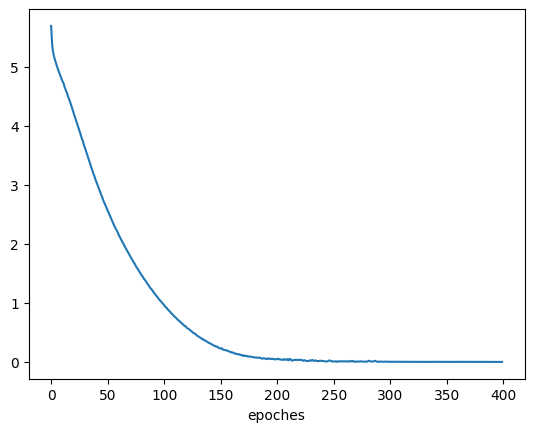

In [34]:
plt.plot(epoch_losses)
plt.xlabel("epoches")

In [35]:
word_embeddings = model_cbow.embeddings.weight.detach().cpu().numpy()

In [36]:
word = 'baller'
word_index = vocab.get_stoi()[word]
print(word_embeddings[word_index])

[-0.4794171  -0.07387315 -0.89620376 -0.14323394  0.3816855  -0.03994514
 -0.13865565  0.8353198   0.792296   -0.0923607  -0.40164903  1.1796134
  0.27540025 -0.20928027  0.8647184   0.33599588 -0.18702847  0.316525
 -0.50021297  0.9679534   0.41439146  0.76559335  0.45962283 -0.5979237 ]


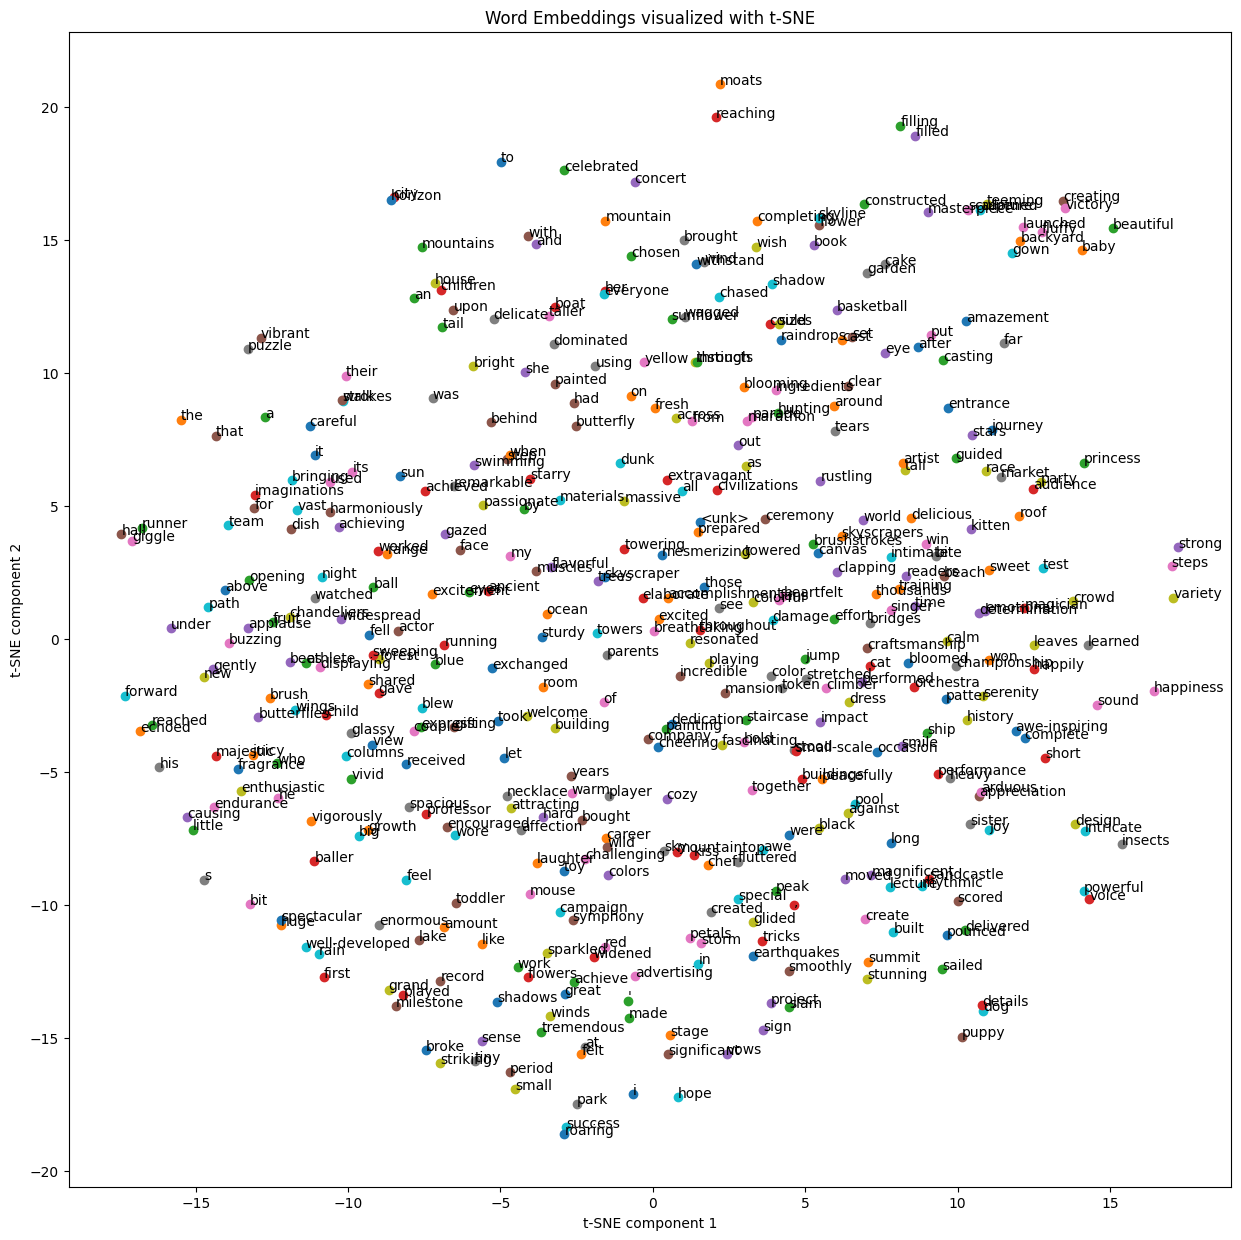

In [37]:
plot_embeddings(word_embeddings,vocab=vocab)

<h2>Skip-gram model</h2>

In [8]:
# Define the window size for context around the target word
CONTEXT_SIZE = 2

# Initialize an empty list to store the (target, context) pairs
skip_data = []

# Iterate over each word in the tokenized toy_data, while excluding the first
# and last few words determined by the CONTEXT_SIZE.
for i in range(CONTEXT_SIZE, len(tokenized_toy_data) - CONTEXT_SIZE):
    # For a word at position i, the context comprises of words from the preceding CONTEXT_SIZE
    # as well as from the succeeding CONTEXT_SIZE. The context words are collected in a list.
    context = (
        [tokenized_toy_data[i - j - 1] for j in range(CONTEXT_SIZE)] # Preceding words
        + [tokenized_toy_data[i + j + 1] for j in range(CONTEXT_SIZE)] # Succeeding words
    )

    # The word at the current position is taken as the target
    target = tokenized_toy_data[i]

    # append the (target, context) pair to the skip_data list.
    skip_data.append((target, context))

In [9]:
skip_data_ = [[(sample[0], word) for word in sample[1]] for sample in skip_data]

In [11]:
skip_data_flat = [item for items in skip_data_ for item in items]
print(skip_data_flat[8:28])

[('little', 'was'), ('little', 'i'), ('little', 'bit'), ('little', 'taller'), ('bit', 'little'), ('bit', 'was'), ('bit', 'taller'), ('bit', 'i'), ('taller', 'bit'), ('taller', 'little'), ('taller', 'i'), ('taller', 'wish'), ('i', 'taller'), ('i', 'bit'), ('i', 'wish'), ('i', 'i'), ('wish', 'i'), ('wish', 'taller'), ('wish', 'i'), ('wish', 'was')]


In [12]:
def collate_fn(batch):
    target_list, context_list = [], []
    for _target, _context in batch:
        target_list.append(vocab[_target])
        context_list.append(vocab[_context])

    target_list = torch.tensor(target_list, dtype=torch.int64)
    context_list = torch.tensor(context_list, dtype=torch.int64)
    return  target_list.to(device), context_list.to(device)

In [19]:
dataloader = DataLoader(
    skip_data_flat,
    batch_size=BATCH_SIZE,
    collate_fn=collate_fn
)

In [ ]:
vocab_idx = vocab.get_itos()
print()

In [22]:
print(next(iter(dataloader)))

(tensor([ 20,  20,  20,  20,   7,   7,   7,   7, 272, 272, 272, 272, 136, 136,
        136, 136, 376, 376, 376, 376,  20,  20,  20,  20, 108, 108, 108, 108,
         20,  20,  20,  20,   7,   7,   7,   7,   2,   2,   2,   2, 133, 133,
        133, 133,  14,  14,  14,  14, 109, 109, 109, 109,   2,   2,   2,   2,
          8,   8,   8,   8, 138, 138, 138, 138]), tensor([108,  20,   7, 272,  20, 108, 272, 136,   7,  20, 136, 376, 272,   7,
        376,  20, 136, 272,  20, 108, 376, 136, 108,  20,  20, 376,  20,   7,
        108,  20,   7,   2,  20, 108,   2, 133,   7,  20, 133,  14,   2,   7,
         14, 109, 133,   2, 109,   2,  14, 133,   2,   8, 109,  14,   8, 138,
          2, 109, 138, 198,   8,   2, 198,  10]))


In [25]:
class SkipGram_Model(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super(SkipGram_Model, self).__init__()

        # embedding layer
        self.embeddings = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embed_dim,
        )

        # the fully connected layer
        self.fc = nn.Linear(
            in_features=embed_dim,
            out_features=vocab_size
        )

    def forward(self, text):
        out = self.embeddings(text)

        out = torch.relu(out)
        out = self.fc(out)

        return out

In [30]:
emsize = 24
model_sg = SkipGram_Model(vocab_size, emsize).to(device)

In [33]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_sg.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)

In [34]:
model_sg, epoch_losses = train_model(
    model_sg,
    dataloader,
    criterion,
    optimizer,
    num_epochs=400
)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:11<00:00,  5.63it/s]


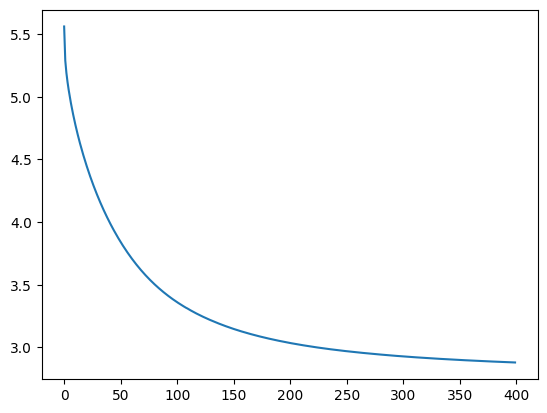

In [35]:
plt.plot(epoch_losses)

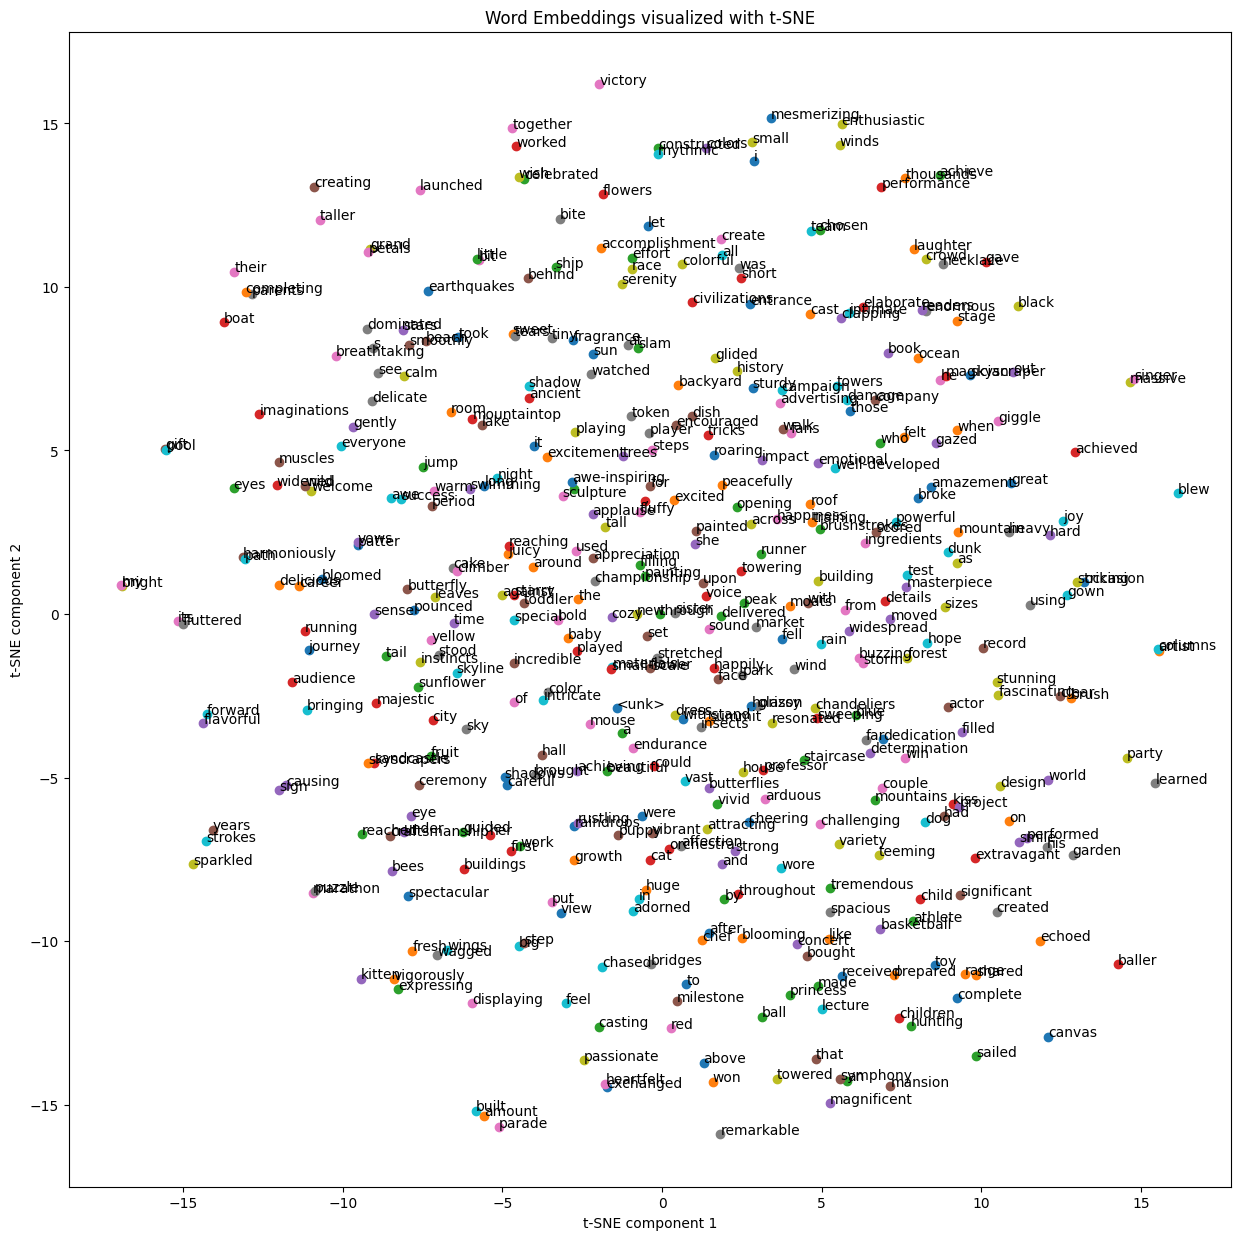

In [36]:
word_embeddings = model_sg.embeddings.weight.detach().cpu().numpy()
plot_embeddings(word_embeddings,vocab=vocab)